# **All dependencies that are necessary**

In [ ]:
!pip install arff
!pip install tensorflow
!pip install --upgrade scipy


In [2]:
import pandas as pd
import numpy as np
from sklearn.metrics import r2_score
from sklearn.model_selection import GridSearchCV
from imblearn.pipeline import Pipeline
from sklearn import preprocessing
from os import listdir
from os.path import isfile, join
from datetime import datetime,date
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras 
from tensorflow.keras import layers
from keras.callbacks import EarlyStopping
from tensorflow.keras import initializers
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import f_regression
from sklearn.feature_selection import r_regression
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import mean_squared_error
from scipy.stats import ttest_ind
import scipy.stats
import seaborn as sns
import math
import json

# **Opening the data set**

The data set is loaded from a CSV file named "meteorological_data" that I created and cleaned in my other python file. Check out "generateData" to obtain more information about.

In [15]:
dataFrame=pd.read_csv('meteorological_data.csv')

dataFrame['mes'] = [mes[5:7] for mes in dataFrame['data completa'] ]
dataFrame['ano'] = [ano[0:4] for ano in dataFrame['data completa'] ]
id_2 = ['A305','A306','A314','A315','A319','A324','A325','A332','A339','A342','A347','A358','A359','A360','A368','A369']
localization = ['FORTALEZA','SOBRAL','GUARAMIRANGA','BARBALHA','IGUATU','TAUA','QUIXERAMOBIM','MORADA NOVA','JAGUARUANA','CRATEUS','CAMPOS SALES','JAGUARIBE','ITAPIPOCA','ACARAU','TIANGUA','QUIXADA']


display(dataFrame)

,TEMPERATURA MAXIMA NA HORA ANT. (AUT)(°C),UMIDADE REL. MAX. NA HORA ANT. (AUT)(%),TEMPERATURA MINIMA NA HORA ANT. (AUT)(°C),UMIDADE REL. MIN. NA HORA ANT. (AUT)(%),RADIACAO GLOBAL(Kj/m²),"PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA(mB)","UMIDADE RELATIVA DO AR, HORARIA(%)","VENTO, VELOCIDADE HORARIA(m/s)",latitude,longitude,altura,estacao_id,dia do ano,data completa,temperatura media,Eo_samani,Eo_FAO,mes,ano
0,29.6,84.0,26.7,68.0,2478.500000,1008.690909,77.636364,2.381818,-0.066599,-0.672610,29.55,0.0,49,2003-02-18,28.15,2.815185,2.158130,02,2003
1,31.5,95.0,24.3,62.0,1320.500000,1008.700000,80.750000,2.329167,-0.066599,-0.672610,29.55,0.0,50,2003-02-19,27.90,4.412632,4.312026,02,2003
2,27.6,95.0,24.1,78.0,2386.444444,1008.354167,88.333333,1.279167,-0.066599,-0.672610,29.55,0.0,51,2003-02-20,25.85,2.939072,3.032922,02,2003
3,30.8,96.0,22.0,61.0,1246.666667,1008.354167,83.083333,1.708333,-0.066599,-0.672610,29.55,0.0,52,2003-02-21,26.40,4.719712,4.768149,02,2003
4,31.2,94.0,24.2,59.0,1431.000000,1008.283333,82.041667,1.858333,-0.066599,-0.672610,29.55,0.0,53,2003-02-22,27.70,4.333662,4.317706,02,2003
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65718,36.8,42.0,31.7,31.0,3055.208250,988.400000,33.500000,3.075000,-0.086896,-0.681677,193.00,15.0,339,2019-12-05,34.25,4.155351,3.864984,12,2019
65719,37.6,33.0,34.7,28.0,2419.698000,985.700000,29.000000,2.200000,-0.086896,-0.681677,193.00,15.0,341,2019-12-07,36.15,3.246348,2.578275,12,2019
65720,34.9,67.0,29.4,40.0,1530.386800,988.720000,51.200000,2.600000,-0.086896,-0.681677,193.00,15.0,342,2019-12-08,32.15,4.138430,3.941287,12,2019
65721,35.1,76.0,26.6,36.0,2624.976200,989.040000,45.400000,3.860000,-0.086896,-0.681677,193.00,15.0,343,2019-12-09,30.85,5.009957,4.618717,12,2019


# **Setting parameters and selecting features**

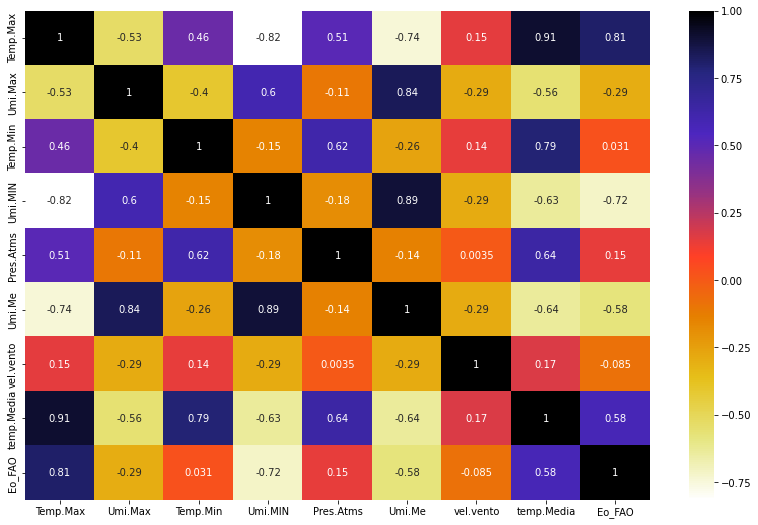

In [ ]:
plt.figure(figsize=(14,9))
correlation = dataFrame.drop(columns=['Eo_samani','latitude','longitude','altura','estacao_id','RADIACAO GLOBAL(Kj/m²)','dia do ano'])
correlation= correlation.rename(columns={'TEMPERATURA MAXIMA NA HORA ANT. (AUT)(°C)':'Temp.Max','UMIDADE REL. MAX. NA HORA ANT. (AUT)(%)':'Umi.Max','TEMPERATURA MINIMA NA HORA ANT. (AUT)(°C)':'Temp.Min','UMIDADE REL. MIN. NA HORA ANT. (AUT)(%)':'Umi.MIN','PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA(mB)':'Pres.Atms','UMIDADE RELATIVA DO AR, HORARIA(%)':'Umi.Me','VENTO, VELOCIDADE HORARIA(m/s)':'vel.vento','temperatura media':'temp.Media'}).corr()
sns.heatmap(correlation,annot =True,cmap = plt.cm.CMRmap_r)
plt.savefig('heapmap.png')
plt.show()

In [ ]:
features_correlation = dict()

for i in range(len(correlation)):
  
  features_correlation[correlation.columns[i]] = []

  for j in range(len(correlation)):
    if correlation.iloc[i,j]>0.6 and i is not j:
      features_correlation[correlation.columns[i]].append(correlation.columns[j])


display(features_correlation)

{'Eo_FAO': ['Temp.Max'],
 'Pres.Atms': ['Temp.Min', 'temp.Media'],
 'Temp.Max': ['temp.Media', 'Eo_FAO'],
 'Temp.Min': ['Pres.Atms', 'temp.Media'],
 'Umi.MIN': ['Umi.Max', 'Umi.Me'],
 'Umi.Max': ['Umi.MIN', 'Umi.Me'],
 'Umi.Me': ['Umi.Max', 'Umi.MIN'],
 'temp.Media': ['Temp.Max', 'Temp.Min', 'Pres.Atms'],
 'vel.vento': []}

In [ ]:
param_grid = {
    'learning_rate':[0.001, 0.01],
    'layer_number':[1,2,3,4],
    'neuron_number':[3,4,5,6,7],
    'features_delete':[
                       ['PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA(mB)','RADIACAO GLOBAL(Kj/m²)','VENTO, VELOCIDADE HORARIA(m/s)'],
                       ['UMIDADE RELATIVA DO AR, HORARIA(%)','UMIDADE REL. MIN. NA HORA ANT. (AUT)(%)','UMIDADE REL. MAX. NA HORA ANT. (AUT)(%)','PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA(mB)','RADIACAO GLOBAL(Kj/m²)','VENTO, VELOCIDADE HORARIA(m/s)'],
    #                   ['RADIACAO GLOBAL(Kj/m²)','temperatura media','UMIDADE RELATIVA DO AR, HORARIA(%)','UMIDADE REL. MAX. NA HORA ANT. (AUT)(%)','TEMPERATURA MINIMA NA HORA ANT. (AUT)(°C)']
                       ],
    #'epochs':[30,40,50,60,70],
    'epochs':[120],
    #'data_date':['2010-02-11','2013-02-11','2015-02-11']
    'data_date':['2003-02-17']
    }
patience = 30
parameters=list(ParameterGrid(param_grid))
display(len(parameters))

80

# **Class and methods used**

This section contains all methods and classes necessary to perform the evapotranspiration predictions by neural network and evaluation of their results. Most functions and methods names are self-explanatory.

##**Classes**



*   Neural_test
  this class is responsible to do all steps necessary to perform the prediction with a certain set of hyperparameters. I provide a short explanation of the main methods.


1.   splitting_data():
It splits the data set into training, validation and test. The Validation set corresponds to 20 percent of the training set. The useless columns are dropped from the data sets.

2.   standardize_data():
Standardize the training and test sets in order to prevent the magnitude of the data does not affect the prediction. the standardization is based on the following equation:

\begin{align}
\frac{(x_i - \mu)}{\sigma}
\end{align}

$x_i$ consists of a data from a data set and $\mu$ and $\sigma$ the mean and standard deviation of this data set.

3.   Model() and Fit(): These functions set up the neural network model with a combination of the hyperparameters. Check out above what hyperparameters I had selected.


In [3]:
class Neural_test:

  def __init__(self,dataframe,drop_columns):

    self.data=dataFrame.drop(labels=drop_columns,axis=1)
  
  def splitting_data(self,date,name_empirical_model):

    empirical_model=[]
    self.data['data completa'] = pd.to_datetime(self.data['data completa'])
    self.data = self.data.set_index(self.data['data completa'])
    self.data = self.data.sort_index()
    
    self.train_dataset = self.data[date[0]:date[1]]
    self.test_dataset  = self.data[date[2]:]
   
    self.test_date=self.test_dataset.index

    self.train_labels = self.train_dataset.loc[:,'Eo_FAO']
    self.test_labels = self.test_dataset.loc[:,'Eo_FAO']

    self.empirical_model=self.test_dataset.loc[:,name_empirical_model]

    self.test_samani = self.test_dataset['Eo_samani']
    self.train_dataset=self.train_dataset.drop(labels=name_empirical_model,axis=1)
    self.test_dataset=self.test_dataset.drop(labels=name_empirical_model,axis=1)

    self.mes = self.test_dataset['mes']
    self.estacao_id = self.test_dataset['estacao_id']
    self.ano = self.test_dataset['ano']

    self.train_dataset=self.train_dataset.drop(labels=['data completa','Eo_FAO','estacao_id','mes','ano'],axis=1)
    self.test_dataset=self.test_dataset.drop(labels=['data completa','Eo_FAO','estacao_id','mes','ano'],axis=1)


  def standardize_data(self):

    scaler = StandardScaler()

    scaler.fit(self.train_dataset)
    self.normed_train_data=pd.DataFrame(scaler.transform(self.train_dataset))
    scaler.fit(self.test_dataset)
    self.normed_test_data=pd.DataFrame(scaler.transform(self.test_dataset))

  def get_train(self):
    return self.train_dataset

  def Model(self,Loss,Metrics,activation_function,Learning_rate,layer_number,neuron_number):

    initializer = tf.keras.initializers.HeNormal(seed=1)
    #initializer = tf.keras.initializers.Zeros()
    model = keras.Sequential()

    for index in range(0,layer_number):
      if index == 0:
        model.add(layers.Dense(neuron_number, activation=activation_function, input_shape=[len(self.normed_train_data.keys())],kernel_initializer=initializer))
      else:
        model.add(layers.Dense(neuron_number, activation=activation_function,kernel_initializer=initializer))
    
    model.add(layers.Dense(1))


    optimizer = tf.keras.optimizers.RMSprop(learning_rate=Learning_rate)
    
    model.compile(loss=Loss,
                optimizer=optimizer,
                metrics=Metrics
                )
    
    self.model=model
    
  def Fit(self,Epochs,Validation_split,Verbose,show_history=True):

    es = EarlyStopping(monitor='val_loss',min_delta=0.00001, verbose=1,patience=30,restore_best_weights=True)
    
    history = self.model.fit(
    x=self.normed_train_data,
    y=self.train_labels,
    validation_split=Validation_split,
    verbose=Verbose,
    epochs=Epochs,
    callbacks=[es]
    )

    if show_history:
      historico = pd.DataFrame(history.history)
      historico['epoch'] = history.epoch
      display(historico.tail())

    return history
    
  def prediction(self):

    self.prediction_test = self.model.predict(self.normed_test_data).flatten()
    self.prediction_test=pd.Series(self.prediction_test)
  
  def compare(self,limit,show=False,name_fig='chooseMyName'):
    
    [test_labels,empirical_model]=[self.test_labels,self.empirical_model]

    if show:
      plt.plot(test_labels[0:limit].reset_index(drop=True),test_labels[0:limit].reset_index(drop=True),label='PM FAO')      
      plt.plot(test_labels[0:limit].reset_index(drop=True),self.prediction_test[0:limit],'x',label='Rede Neural')
      #plt.plot(test_labels[0:limit].reset_index(drop=True),empirical_model[0:limit],'x')
      plt.ylabel('Fao 56')
      plt.xlabel('Fao 56')
      plt.legend()
      plt.grid()
      plt.savefig(name_fig)
      plt.show()

    r2=r2_score(test_labels, self.prediction_test)
    #r2_2=r2_score(test_labels, empirical_model)
    print(r2)
    return r2



class organize():

  def __init__(self,simulation_result):

    self.simulation_result=simulation_result

  def organize_results_two_sets(self,qtd,store_excel=False):

    result_dic=dict()
    result_dic['results_of_simulation00'] = dict()
    result_dic['results_of_simulation01'] = dict()

    condition = [['PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA(mB)', 'RADIACAO GLOBAL(Kj/m²)', 'VENTO, VELOCIDADE HORARIA(m/s)'],['UMIDADE RELATIVA DO AR, HORARIA(%)', 'UMIDADE REL. MIN. NA HORA ANT. (AUT)(%)', 'UMIDADE REL. MAX. NA HORA ANT. (AUT)(%)', 'PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA(mB)', 'RADIACAO GLOBAL(Kj/m²)', 'VENTO, VELOCIDADE HORARIA(m/s)']]

    for index in range(len(simulation_result['id'])):

      #result_dic['simulation '+str(index)]={'parameters':simulation_result['parameters'][index],'id':simulation_result['id'][index],'history':simulation_result['history'][index],'result':simulation_result['result'][index]}
      for index2 in range(len(condition)):
        if simulation_result['parameters'][index]['features_delete'] == condition[index2]: 
          result_dic['results_of_simulation0'+str(index2)][simulation_result['id'][index]] = dict()
          result_dic['results_of_simulation0'+str(index2)][simulation_result['id'][index]]['result_R2']=simulation_result['result_R2'][index]
          result_dic['results_of_simulation0'+str(index2)][simulation_result['id'][index]]['result_MSE']=simulation_result['result_MSE'][index]
          result_dic['results_of_simulation0'+str(index2)][simulation_result['id'][index]]['parameters']=simulation_result['parameters'][index]
          print(simulation_result['parameters'][index])
    results_of_simulation00 = sorted(result_dic['results_of_simulation00'].items(), key=lambda item: item[1]['result_R2'])
    results_of_simulation01 = sorted(result_dic['results_of_simulation01'].items(), key=lambda item: item[1]['result_R2'])
    
    if store_excel:

      pd.DataFrame(results_of_simulation00).to_excel("results_of_simulation00.xlsx",index=False)
      pd.DataFrame(results_of_simulation01).to_excel("results_of_simulation01.xlsx",index=False)
    
    return [results_of_simulation00,results_of_simulation01]


##**Functions**

In [4]:
def creating_two_boxplot(data_01,data_02,ylabel,showfliersC,salve_picture=False,name_picture='YouForgotMyNamae'):

  plt.boxplot(data_01,showfliers=showfliersC)
  plt.boxplot(data_02,showfliers=showfliersC,positions=[2])
  plt.xlabel('Boxplot')
  plt.ylabel(ylabel)
  #plt.title(title)
  plt.grid()
  if salve_picture:
    plt.savefig(name_picture)
  plt.show()


def Creating_result_table(results_dict,load_dataset_from_excel):

  matrix = []

  if load_dataset_from_excel:
    for id in range(len(results_dict),0,-1):
      matrix.append([results_dict[id]['parameters']['data_date'],len(results_dict[id]['parameters']['features_delete']),results_dict[id]['parameters']['learning_rate'],results_dict[id]['result_MSE'],results_dict[id]['result_R2'],results_dict[id]['parameters']['layer_number'],results_dict[id]['parameters']['neuron_number'],results_dict[id]['parameters']['epochs'] ])
  else:
    for id in range(len(results_dict)-1,0,-1):
      matrix.append([results_dict[id][1]['parameters']['data_date'],len(results_dict[id][1]['parameters']['features_delete']),results_dict[id][1]['parameters']['learning_rate'],results_dict[id][1]['result_MSE'],results_dict[id][1]['result_R2'],results_dict[id][1]['parameters']['layer_number'],results_dict[id][1]['parameters']['neuron_number'],results_dict[id][1]['parameters']['epochs']])
  
  matrix = pd.DataFrame(matrix).rename(columns={0:'Data de inicio',1:'features deletadas',2:'taxa de aprendizagem',3:'MSE',4:'coeficiente de determinação',5:'Número de camadas',6:'número de neurônios',7:'épocas'})
  
  return matrix

def make_prediction(dataFrame,parameter):

  neural_network = Neural_test(dataFrame,parameter['features_delete'])  
  neural_network.splitting_data([parameter['data_date'],'2018-01-01','2018-01-02'],['Eo_samani'])
  neural_network.standardize_data()
  neural_network.Model('mse',['mae', 'mse'],'relu',parameter['learning_rate'],parameter['layer_number'],parameter['neuron_number'])
  history = neural_network.Fit(parameter['epochs'],0.2,0,False)

  neural_network.prediction()
  neural_network.compare(350)
  return  [neural_network,history]



def get_results(parameters,patience):
  
  [index,simulation_result,keys,mse] = [0,dict(),['parameters','result_R2','result_MSE','id','history'],0]

  for key in keys:
    simulation_result[key] = [] 

  for parameter in parameters:

    print('Parameters used:\n Features para serem deletadas: '+str(parameter['features_delete'])+' taxa de aprendizagem: '+str(parameter['learning_rate'])+' Epochs: '+str(parameter['epochs'])+' data: '+parameter['data_date'])
    print('numero de layers: '+str(parameter['layer_number'])+' numero de neuronios: '+str(parameter['neuron_number'])+'\n' )
    neural_network = Neural_test(dataFrame,parameter['features_delete'])
    neural_network.splitting_data([parameter['data_date'],'2018-01-01','2018-01-02'],['Eo_samani'])
    neural_network.standardize_data()
    
    neural_network.Model('mse',['mae', 'mse'],'relu',parameter['learning_rate'],parameter['layer_number'],parameter['neuron_number'])
    
    history = neural_network.Fit(parameter['epochs'],0.2,0,True)
    neural_network.prediction()
    
    coeficent=neural_network.compare(250)
    mse=mean_squared_error(neural_network.test_labels,neural_network.prediction_test)
    parameter["epochs"] = len(history.history["mse"])-patience
    simulation_result['parameters'].append(parameter) 
    simulation_result['id'].append(index)
    simulation_result['result_R2'].append(coeficent)
    simulation_result['result_MSE'].append(mse)
    simulation_result['history'] = history
    display(mse)
    print(index)
    index+=1

  return simulation_result



def get_results_with_same_weight(parameter,weight,patience,epochs_max,n):
  
  [index,simulation_result,keys,mse] = [0,dict(),['parameters','result_R2','result_MSE','id'],0]

  for key in keys:
    simulation_result[key] = [] 

  neural_network = Neural_test(dataFrame,parameter['features_delete'])
  neural_network.splitting_data([parameter['data_date'],'2018-01-01','2018-01-02'],['Eo_samani'])
  neural_network.standardize_data()
    
  neural_network.Model('mse',['mae', 'mse'],'relu',parameter['learning_rate'],parameter['layer_number'],parameter['neuron_number'])
  
  
  for index in range(n):

    print('Parameters used:\n Features para serem deletadas: '+str(parameter['features_delete'])+' taxa de aprendizagem: '+str(parameter['learning_rate'])+' Epochs: '+str(parameter['epochs'])+' data: '+parameter['data_date'])
    print('numero de layers: '+str(parameter['layer_number'])+' numero de neuronios: '+str(parameter['neuron_number'])+'\n' )
    
    neural_network.model.set_weights(weight)
    
    history = neural_network.Fit(epochs_max,0.2,0,True)
    neural_network.prediction()
    
    coeficent=neural_network.compare(250)
    mse=mean_squared_error(neural_network.test_labels,neural_network.prediction_test)
    parameter["epochs"] = len(history.history["mse"])-patience
    simulation_result['id'].append(index)
    simulation_result['result_R2'].append(coeficent)
    simulation_result['result_MSE'].append(mse)
    print(mse)
    print(index)
    print(coeficent)

  return simulation_result


def get_results_stored_in_excel_and_convert_to_dict(name_excel):
    
  excel = pd.read_excel(name_excel)

  dataset = dict()
  
  for index in range(len(excel[1])-1,0,-1):
        
    dataset[index] = dict()
    json_data = json.loads(excel[1][index].replace("'",'"'))
    dataset[index]['parameters'] = json_data['parameters']
    dataset[index]['result_R2'] = json_data['result_R2']
    dataset[index]['result_MSE'] = json_data['result_MSE']

  return dataset


def trim_axs(axs, N):
    """
    Reduce *axs* to *N* Axes. All further Axes are removed from the figure.
    """
    axs = axs.flat
    for ax in axs[N:]:
        ax.remove()
    return axs[:N]


def get_graphs_and_metrics_grouped_by_estacao_id_2(prediction,test,split,year,localization,id_2,simulation_id,save_picture = False,show_picture = False):

  prediction_labels_gruopby_estacao_id = [x for x in prediction[prediction['ano']==year].groupby('estacao_id')]
  test_labels_gruopby_estacao_id = [x for x in test[test['ano']==year].groupby('estacao_id')]  

  fig, axs = plt.subplots(16, 3,figsize=(17,35))
  labels = ['FAO','samani','Rede_Neural']
  station_name_index = [int(estation[1]['estacao_id'][0]) for estation in test_labels_gruopby_estacao_id]
  results_simulations_by_estation = dict()

  line_number = 0
  count = 0
  for index in range(len(station_name_index)):
    
    results_simulations_by_estation[localization[station_name_index[index] ] ] = dict()
    
    results_simulations_by_estation[localization[station_name_index[index] ] ]['código da estação'] = id_2[index]
    results_simulations_by_estation[localization[station_name_index[index] ] ]['Quantidade de dados'] = len(prediction_labels_gruopby_estacao_id[index][1]) 
    
    prediction_labels_gruopby_estacao_id_groupby_month=prediction_labels_gruopby_estacao_id[index][1].groupby([split]).mean().drop(columns={'estacao_id'})
    test_labels_gruopby_estacao_id_groupby_month=test_labels_gruopby_estacao_id[index][1].groupby([split]).mean().drop(columns={'estacao_id'})
    
    results_simulations_by_estation[localization[station_name_index[index] ] ]['coeficiente de determinação(dia)'] = r2_score(test_labels_gruopby_estacao_id[index][1]['Eo_FAO'],prediction_labels_gruopby_estacao_id[index][1][0])
    results_simulations_by_estation[localization[station_name_index[index] ] ]['MSE(dia)'] = mean_squared_error(test_labels_gruopby_estacao_id[index][1]['Eo_FAO'],prediction_labels_gruopby_estacao_id[index][1][0])

    coeficient_of_determination = r2_score(prediction_labels_gruopby_estacao_id_groupby_month,test_labels_gruopby_estacao_id_groupby_month)

    results_simulations_by_estation[localization[station_name_index[index] ] ]['coeficiente de determinação(mes)'] = coeficient_of_determination
    results_simulations_by_estation[localization[station_name_index[index] ] ]['MSE(mes)'] = mean_squared_error(prediction_labels_gruopby_estacao_id_groupby_month,test_labels_gruopby_estacao_id_groupby_month)


    axs[line_number,count].plot(prediction_labels_gruopby_estacao_id[index][1][0].reset_index(drop=True),':', label = 'Rede Neural')
    axs[line_number,count].plot(test_labels_gruopby_estacao_id[index][1]['Eo_FAO'].reset_index(drop=True),':', label = 'FAO-56')
    axs[line_number,count].set_title(localization[index])
    axs[line_number,count].legend()
    axs[line_number,count].grid()

    count+=1

    axs[line_number,count].plot(prediction_labels_gruopby_estacao_id_groupby_month, label = 'Rede Neural')
    axs[line_number,count].plot(test_labels_gruopby_estacao_id_groupby_month, label = 'FAO-56')
    axs[line_number,count].set_title(localization[index])
    axs[line_number,count].legend()
    axs[line_number,count].grid()

    count+=1

    axs[line_number,count].plot(test_labels_gruopby_estacao_id[index][1]['Eo_FAO'].drop(columns={'estacao_id','mes'}),test_labels_gruopby_estacao_id[index][1]['Eo_FAO'].drop(columns={'estacao_id','mes'}),label = 'FAO-56')
    axs[line_number,count].plot(test_labels_gruopby_estacao_id[index][1]['Eo_FAO'].drop(columns={'estacao_id','mes'}),prediction_labels_gruopby_estacao_id[index][1][0].drop(columns={'estacao_id','mes'}),'xb',label = 'Rede Neural')
    axs[line_number,count].set_title(localization[index])
    axs[line_number,count].legend()
    axs[line_number,count].grid()


    line_number+=1
    count=0
  for ax in axs.flat:
      ax.set(xlabel='mes', ylabel='Eo')

  for ax in axs.flat:
      ax.label_outer()
  
  
  plt.savefig(f"simulation {simulation_id}")
  return pd.DataFrame(results_simulations_by_estation)



# **Prediction and Tuning**

In this section, the training results of the neural network models are going to shown and their hyperparameters will be selected based on the highest coefficients of determination. The algorithm makes and stores 90 predictions using all combinations of the above hyperparameters.                           

**Read-me**: The procedure of doing all training and predictions and obtaining the metrics from each hyperparameter takes too much time. To avoid this problem, I already saved the best results in two CSV files named "results_of_simulation00.xlsx" and "results_of_simulation01.xlsx". Set the  "load_dataset_from_excel" variable as True and you are going to be able to access the results as much as the parameters used without redoing the model training. 

In [11]:
load_dataset_from_excel = True

if load_dataset_from_excel:
  best_results_of_simulation00 = get_results_stored_in_excel_and_convert_to_dict('results_of_simulation00.xlsx')
  best_results_of_simulation01 = get_results_stored_in_excel_and_convert_to_dict('results_of_simulation01.xlsx')

else:
  simulation_result = get_results(parameters,patience)
  organizing = organize(simulation_result)
  [best_results_of_simulation00,best_results_of_simulation01] = organizing.organize_results_two_sets(True,10)

result_table00 = Creating_result_table(best_results_of_simulation00,load_dataset_from_excel)
result_table01 = Creating_result_table(best_results_of_simulation01,load_dataset_from_excel)

In [12]:
parameter00 = {
    'learning_rate':result_table00[0:1]['taxa de aprendizagem'][0],
#    'momentum' : [0.0, 0.2, 0.4, 0.6],
    'features_delete':
                       ['PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA(mB)','RADIACAO GLOBAL(Kj/m²)','VENTO, VELOCIDADE HORARIA(m/s)'],
    'epochs':result_table00[0:1]['épocas'][0],
    'data_date':result_table00[0:1]['Data de inicio'][0],
    'layer_number':result_table00[0:1]['Número de camadas'][0],
    'neuron_number':result_table00[0:1]['número de neurônios'][0]
    }

display(result_table00[:15].drop(columns=['Data de inicio','features deletadas']))
display(result_table00.groupby(['Número de camadas','número de neurônios','épocas','taxa de aprendizagem']).mean().drop(columns={'features deletadas'}).iloc[0:20,:])

,taxa de aprendizagem,MSE,coeficiente de determinação,Número de camadas,número de neurônios,épocas
0,0.001,0.038800,0.956238,3,5,75
1,0.001,0.040845,0.953931,4,7,66
2,0.001,0.041736,0.952926,4,6,67
3,0.001,0.041848,0.952799,2,7,34
4,0.010,0.041998,0.952630,3,7,71
5,0.001,0.042400,0.952176,3,6,15
6,0.001,0.043815,0.950580,3,4,90
7,0.001,0.044652,0.949637,2,6,41
8,0.010,0.046589,0.947452,2,3,27
9,0.010,0.046830,0.947180,3,5,34


MSE  \
Número de camadas número de neurônios épocas taxa de aprendizagem             
1                 3                   44     0.010                 0.071326   
                                      60     0.001                 0.072126   
                  4                   19     0.010                 0.064016   
                                      65     0.001                 0.134977   
                  5                   33     0.001                 0.074089   
                                      51     0.010                 0.063063   
                  6                   37     0.010                 0.068365   
                                      50     0.001                 0.112425   
                  7                   11     0.001                 0.076115   
                                      21     0.010                 0.051929   
2                 3                   27     0.010                 0.046589   
                  4                   35     0.010                 0.053578   
                                      70     0.001                 0.057542   
                  5                   30     0.010                 0.052208   
                                      78     0.001                 0.069234   
                  6                   41     0.001                 0.044652   
                                      61     0.010                 0.051723   
                  7                   17     0.010                 0.049572   
                                      34     0.001                 0.041848   
3                 3                   16     0.001                 0.059591   

                                                                   coeficiente de determinação  
Número de camadas número de neurônios épocas taxa de aprendizagem                               
1                 3                   44     0.010                                    0.919551  
                                      60     0.001                                    0.918649  
                  4                   19     0.010                                    0.927796  
                                      65     0.001                                    0.847759  
                  5                   33     0.001                                    0.916434  
                                      51     0.010                                    0.928871  
                  6                   37     0.010                                    0.922891  
                                      50     0.001                                    0.873196  
                  7                   11     0.001                                    0.914150  
                                      21     0.010                                    0.941430  
2                 3                   27     0.010                                    0.947452  
                  4                   35     0.010                                    0.939569  
                                      70     0.001                                    0.935098  
                  5                   30     0.010                                    0.941114  
                                      78     0.001                                    0.921911  
                  6                   41     0.001                                    0.949637  
                                      61     0.010                                    0.941661  
                  7                   17     0.010                                    0.944088  
                                      34     0.001                                    0.952799  
3                 3                   16     0.001                                    0.932787

In [13]:
parameter01 = {
    'learning_rate':result_table01[0:1]['taxa de aprendizagem'][0],
#    'momentum' : [0.0, 0.2, 0.4, 0.6],
    'features_delete':
                       ['PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA(mB)','RADIACAO GLOBAL(Kj/m²)','VENTO, VELOCIDADE HORARIA(m/s)'],
    'epochs':result_table01[0:1]['épocas'][0],
    'data_date':result_table01[0:1]['Data de inicio'][0],
    'layer_number':result_table01[0:1]['Número de camadas'][0],
    'neuron_number':result_table01[0:1]['número de neurônios'][0]
    }
display(result_table01[0:15].drop(columns=['Data de inicio','features deletadas']))
result_table01.groupby(['Número de camadas','número de neurônios','épocas','taxa de aprendizagem']).mean().drop(columns={'features deletadas'}).iloc[0:30,:]

,taxa de aprendizagem,MSE,coeficiente de determinação,Número de camadas,número de neurônios,épocas
0,0.001,0.041023,0.953730,3,7,59
1,0.001,0.041142,0.953596,2,7,29
2,0.010,0.041283,0.953437,4,3,43
3,0.010,0.044028,0.950340,3,7,5
4,0.010,0.044430,0.949888,2,5,21
5,0.010,0.045213,0.949004,4,5,33
6,0.001,0.046030,0.948082,3,6,54
7,0.010,0.046614,0.947424,2,7,27
8,0.001,0.048105,0.945742,2,6,54
9,0.001,0.048772,0.944990,2,5,90


MSE  \
Número de camadas número de neurônios épocas taxa de aprendizagem             
1                 3                   50     0.001                 0.143381   
                                      54     0.010                 0.085390   
                  4                   13     0.010                 0.066697   
                                      15     0.001                 0.085760   
                  5                   44     0.010                 0.064315   
                                      54     0.001                 0.063393   
                  6                   47     0.010                 0.058391   
                                      76     0.001                 0.064494   
                  7                   90     0.001                 0.096658   
                                             0.010                 0.080830   
2                 3                   25     0.001                 0.071102   
                                      77     0.010                 0.066715   
                  4                   26     0.010                 0.054318   
                                      90     0.001                 0.062644   
                  5                   21     0.010                 0.044430   
                                      90     0.001                 0.048772   
                  6                   41     0.010                 0.052519   
                                      54     0.001                 0.048105   
                  7                   27     0.010                 0.046614   
                                      29     0.001                 0.041142   
3                 3                   55     0.010                 0.053809   
                  4                   52     0.001                 0.051028   
                                      64     0.010                 0.049598   
                  5                   55     0.010                 0.050625   
                                      90     0.001                 0.072374   
                  6                   22     0.010                 0.049328   
                                      54     0.001                 0.046030   
                  7                   5      0.010                 0.044028   
                                      59     0.001                 0.041023   
4                 3                   39     0.001                 0.059386   

                                                                   coeficiente de determinação  
Número de camadas número de neurônios épocas taxa de aprendizagem                               
1                 3                   50     0.001                                    0.838280  
                                      54     0.010                                    0.903688  
                  4                   13     0.010                                    0.924772  
                                      15     0.001                                    0.903271  
                  5                   44     0.010                                    0.927459  
                                      54     0.001                                    0.928499  
                  6                   47     0.010                                    0.934140  
                                      76     0.001                                    0.927257  
                  7                   90     0.001                                    0.890979  
                                             0.010                                    0.908832  
2                 3                   25     0.001                                    0.919803  
                                      77     0.010                                    0.924752  
                  4                   26     0.010                                    0.938735  
                                      90     0.001                                    0.

# **Evaluating the results**

## **All results of the simulation 00**

This subsection is included the graphs and metrics such as  $r^2$ and MSE per monthly mean and day. The graphs that present the monthly mean results are related to 2018, the year which contains most data from the test data set.

0.9353597948026191


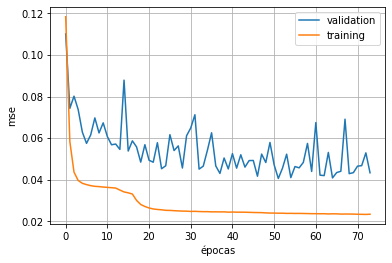

In [16]:
if load_dataset_from_excel:
  [modelo,history] = make_prediction(dataFrame,best_results_of_simulation00[len(best_results_of_simulation00)]['parameters'])
else:
  results_of_simulation00 = sorted(best_results_of_simulation00, key=lambda item: item[1]['result_R2'])
  [modelo,history] = make_prediction(dataFrame,best_results_of_simulation00[len(best_results_of_simulation00)-1][1]['parameters'])

plt.plot(history.history['val_mse'][1:len(history.history['val_mse'])], label = "validation")
plt.plot(history.history['mse'][1:len(history.history['val_mse'])], label = "training")
plt.xlabel('épocas')
plt.ylabel('mse')
plt.grid()
plt.legend()
#plt.savefig("validation_training.png")
plt.show()

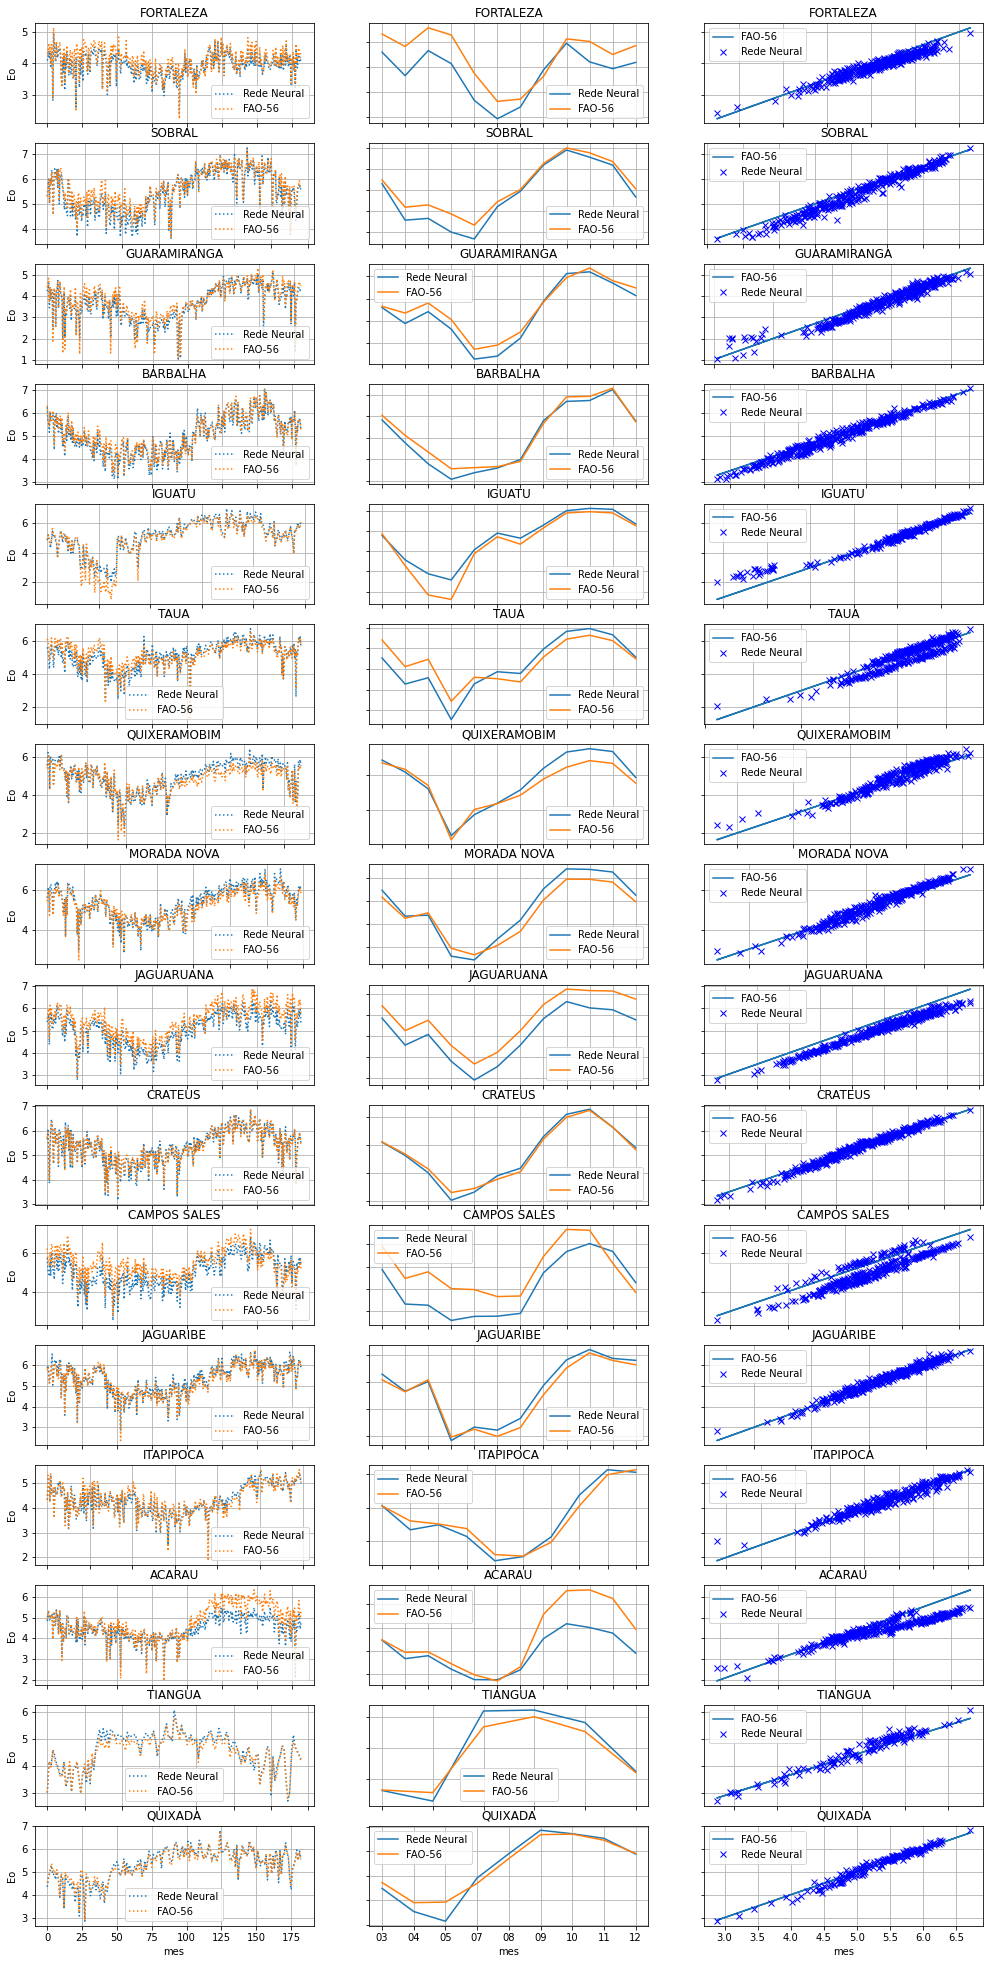

In [17]:
test_labels = pd.DataFrame(modelo.test_labels)
prediction_test = pd.DataFrame(modelo.prediction_test)

test_labels['data'] = modelo.test_labels.index
prediction_test['data'] = modelo.test_labels.index

test_labels['mes'] = [mes for mes in modelo.mes]
prediction_test['mes'] = [mes for mes in modelo.mes]
test_labels['ano'] = [mes for mes in modelo.ano]
prediction_test['ano'] = [mes for mes in modelo.ano]

test_labels_gruopby_data = test_labels.groupby(['data']).mean()
prediction_test_gruopby_data = prediction_test.groupby(['data']).mean()

test_labels_gruopby_month = test_labels.groupby(['mes']).mean()
prediction_test_gruopby_month = prediction_test.groupby(['mes']).mean()

test_labels['estacao_id'] = [id for id in modelo.estacao_id ]
prediction_test['estacao_id'] = [id for id in modelo.estacao_id ]

simulation_id = ' graphs 01'

results_by_estation00 = get_graphs_and_metrics_grouped_by_estacao_id_2(prediction_test,test_labels,'mes','2018',localization,id_2,simulation_id,show_picture = True)

In [18]:
display(results_by_estation00.T)

,código da estação,Quantidade de dados,coeficiente de determinação(dia),MSE(dia),coeficiente de determinação(mes),MSE(mes)
FORTALEZA,A305,364,0.810591,0.02986,0.259983,0.024394
SOBRAL,A306,341,0.892981,0.052821,0.898588,0.048054
GUARAMIRANGA,A314,361,0.916143,0.053426,0.934564,0.02674
BARBALHA,A315,364,0.958907,0.025376,0.962709,0.018281
IGUATU,A319,247,0.92987,0.116628,0.850504,0.196595
TAUA,A324,363,0.789999,0.102098,0.782261,0.081593
QUIXERAMOBIM,A325,323,0.851219,0.073148,0.907231,0.05192
MORADA NOVA,A332,348,0.919955,0.042183,0.930751,0.03113
JAGUARUANA,A339,364,0.732403,0.147475,0.592916,0.137978
CRATEUS,A342,364,0.974536,0.010117,0.985515,0.003615


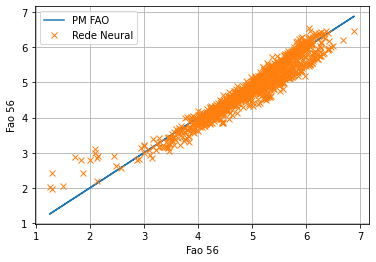

0.9353597948026191


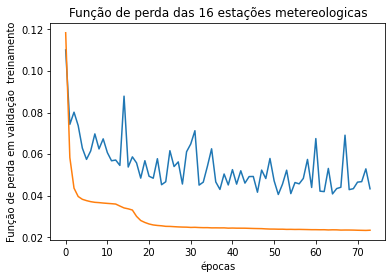

In [19]:
modelo.compare(1000,True,'dispersaoResult01')
plt.plot(history.history['val_loss'][1:],label = 'Validação')
plt.plot(history.history['loss'][1:], label = 'Treinamento')
plt.title('Função de perda das 16 estações metereologicas')
plt.xlabel('épocas')
plt.ylabel('Função de perda em validação  treinamento')
plt.show()

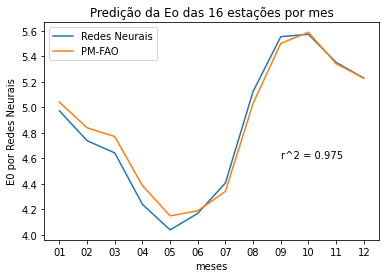

0.9747094534687367

In [20]:
plt.plot(prediction_test_gruopby_month, label = 'Redes Neurais')
plt.plot(test_labels_gruopby_month, label = 'PM-FAO')
plt.legend()
plt.text(8,4.6,'r^2 = '+str(round(r2_score(prediction_test_gruopby_month,test_labels_gruopby_month),3)))
plt.xlabel('meses')
plt.ylabel('E0 por Redes Neurais')
plt.title('Predição da Eo das 16 estações por mes')
plt.show()

display(r2_score(prediction_test_gruopby_month,test_labels_gruopby_month))

## **All results of the simulation 01**

This subsection is included the graphs and metrics such as  $r^2$ and MSE per monthly mean and day. The graphs that present the monthly mean results are related to 2018, the year which contains most data from the test data set.

0.9479958759133393


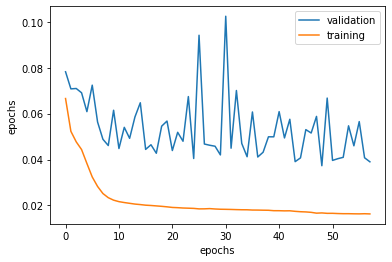

In [ ]:
if load_dataset_from_excel:
  [modelo,history] = make_prediction(dataFrame,best_results_of_simulation01[len(best_results_of_simulation01)]['parameters'])
else:
  best_results_of_simulation01 = sorted(best_results_of_simulation01, key=lambda item: item[1]['result_R2'])
  [modelo,history] = make_prediction(dataFrame,best_results_of_simulation01[len(best_results_of_simulation01)-1][1]['parameters'])

plt.plot(history.history['val_mse'][1:len(history.history['val_mse'])], label = "validation")
plt.plot(history.history['mse'][1:len(history.history['val_mse'])], label = "training")
plt.xlabel('epochs')
plt.ylabel('epochs')
plt.legend()
plt.show()

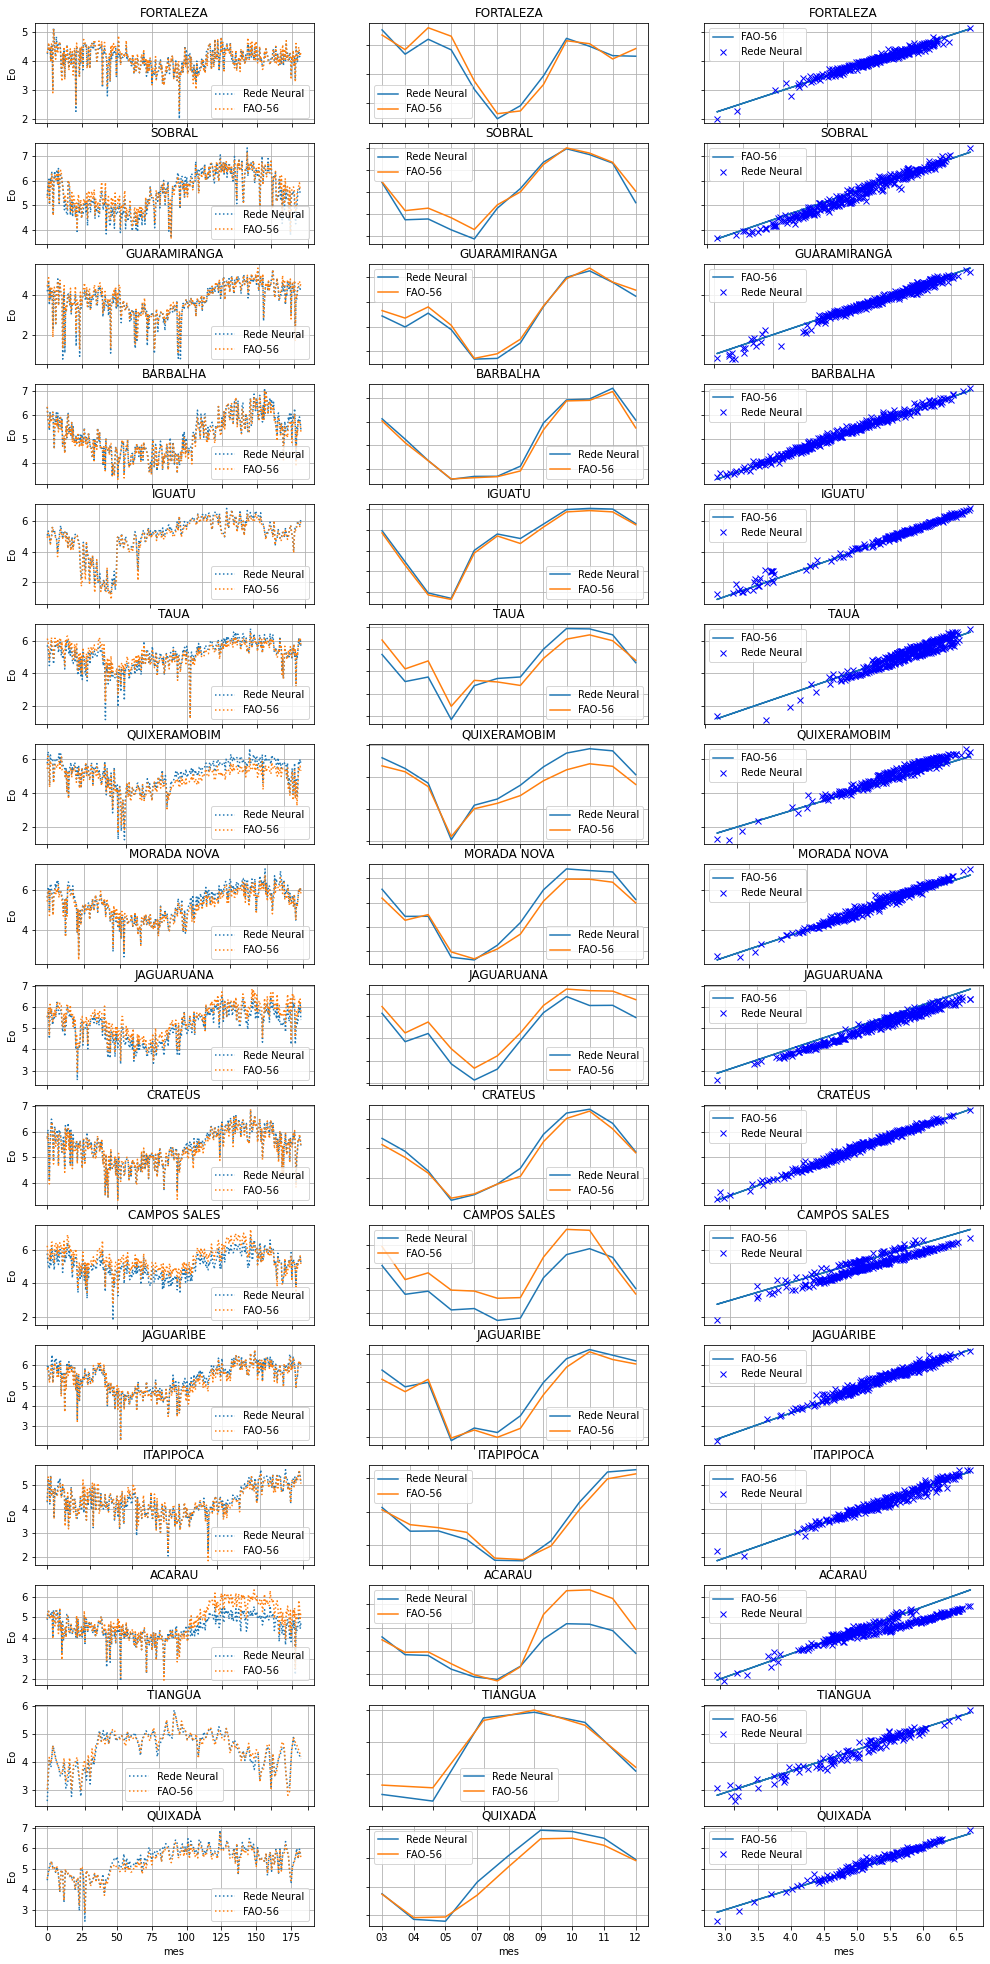

In [ ]:
test_labels = pd.DataFrame(modelo.test_labels)
prediction_test = pd.DataFrame(modelo.prediction_test)

test_labels['data'] = modelo.test_labels.index
prediction_test['data'] = modelo.test_labels.index

test_labels['mes'] = [mes for mes in modelo.mes]
prediction_test['mes'] = [mes for mes in modelo.mes]
test_labels['ano'] = [mes for mes in modelo.ano]
prediction_test['ano'] = [mes for mes in modelo.ano]

test_labels_gruopby_data = test_labels.groupby(['data']).mean()
prediction_test_gruopby_data = prediction_test.groupby(['data']).mean()

test_labels_gruopby_month = test_labels.groupby(['mes']).mean()
prediction_test_gruopby_month = prediction_test.groupby(['mes']).mean()

test_labels['estacao_id'] = [id for id in modelo.estacao_id ]
prediction_test['estacao_id'] = [id for id in modelo.estacao_id ]

simulation_id = ' graphs 02'
#display(prediction_test)

results_by_estation01 = get_graphs_and_metrics_grouped_by_estacao_id_2(prediction_test,test_labels,'mes','2018',localization,id_2,simulation_id,show_picture = True)

In [ ]:
display(results_by_estation01.T)

,código da estação,Quantidade de dados,coeficiente de determinação(dia),MSE(dia),coeficiente de determinação(mes),MSE(mes)
FORTALEZA,A305,364,0.951589,0.007632,0.925928,0.002522
SOBRAL,A306,341,0.932188,0.033469,0.943359,0.025425
GUARAMIRANGA,A314,361,0.963266,0.023404,0.97467,0.008573
BARBALHA,A315,364,0.979316,0.012773,0.986698,0.006221
IGUATU,A319,247,0.980494,0.032439,0.991691,0.016948
TAUA,A324,363,0.869562,0.063416,0.851849,0.049591
QUIXERAMOBIM,A325,323,0.74327,0.12622,0.839586,0.102838
MORADA NOVA,A332,348,0.935253,0.03412,0.940981,0.024803
JAGUARUANA,A339,364,0.854062,0.080427,0.798594,0.072266
CRATEUS,A342,364,0.973645,0.010471,0.974477,0.006311


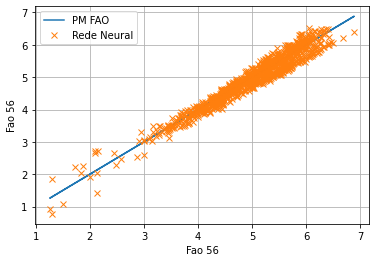

0.9479958759133393


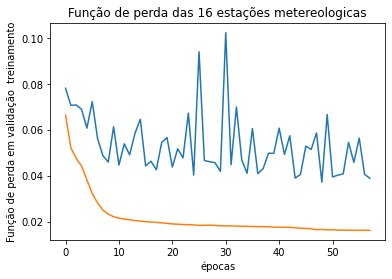

In [ ]:
modelo.compare(1000,True)
plt.title('Função de perda das 16 estações metereologicas')
plt.xlabel('épocas')
plt.ylabel('Função de perda em validação  treinamento')
plt.plot(history.history['val_loss'][1:len(history.history['val_mse'])], label = 'validação')
plt.plot(history.history['loss'][1:len(history.history['val_mse'])], label = 'treinamento')
plt.show()

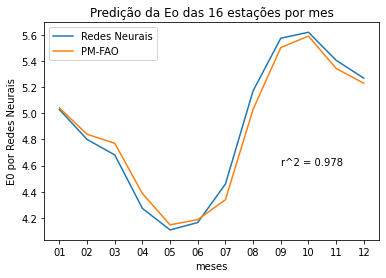

0.978489245894864

In [ ]:
plt.plot(prediction_test_gruopby_month, label = 'Redes Neurais')
plt.plot(test_labels_gruopby_month, label = 'PM-FAO')
plt.legend()
plt.text(8,4.6,'r^2 = '+str(round(r2_score(prediction_test_gruopby_month,test_labels_gruopby_month),3)))
plt.xlabel('meses')
plt.ylabel('E0 por Redes Neurais')
plt.title('Predição da Eo das 16 estações por mes')
plt.show()

display(r2_score(prediction_test_gruopby_month,test_labels_gruopby_month))

## The top 5 best results

In [ ]:
results_by_estation01_transpose = results_by_estation01.T
alfa = 0.96

best_r2_per_day = results_by_estation00_transpose[results_by_estation01_transpose['coeficiente de determinação(dia)']>alfa]

best_r2_per_day = best_r2_per_day.sort_values(by=['coeficiente de determinação(dia)'],ascending=False)
display(best_r2_per_day)

alfa = 0.02

best_r2_per_day = results_by_estation01_transpose[results_by_estation01_transpose['MSE(dia)']<alfa]

best_r2_per_day = best_r2_per_day.sort_values(by=['MSE(dia)'])

display(best_r2_per_day)



,código da estação,Quantidade de dados,coeficiente de determinação(dia),MSE(dia),coeficiente de determinação(mes),MSE(mes)
CRATEUS,A342,364,0.980949,0.007569,0.991506,0.00199
BARBALHA,A315,364,0.978266,0.013421,0.984175,0.006938
QUIXADA,A369,183,0.969677,0.012003,0.977241,0.007408


,código da estação,Quantidade de dados,coeficiente de determinação(dia),MSE(dia),coeficiente de determinação(mes),MSE(mes)
CRATEUS,A342,364,0.980949,0.007569,0.991506,0.00199
QUIXADA,A369,183,0.969677,0.012003,0.977241,0.007408
BARBALHA,A315,364,0.978266,0.013421,0.984175,0.006938
FORTALEZA,A305,364,0.913897,0.013574,0.86682,0.005719
TIANGUA,A368,137,0.953732,0.016483,0.97316,0.00605


## **Seaching for outliers**

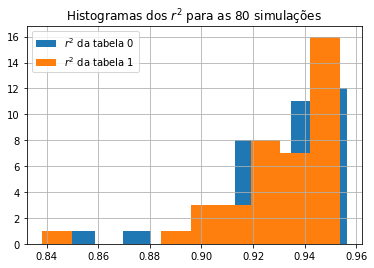

In [ ]:
plt.hist(result_table00['coeficiente de determinação'],label='$r^2$ da tabela 0')
plt.hist(result_table01['coeficiente de determinação'],label='$r^2$ da tabela 1')
plt.grid()
plt.legend()
plt.title('Histogramas dos $r^2$ para as 80 simulações')
plt.show()

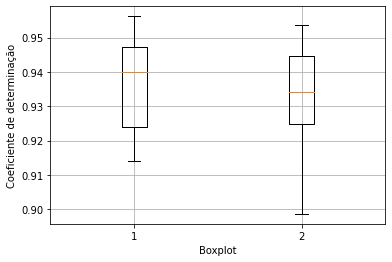

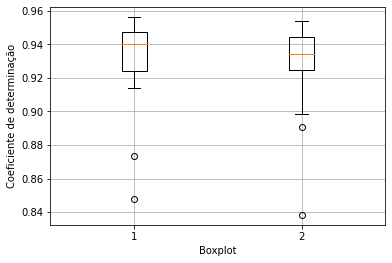

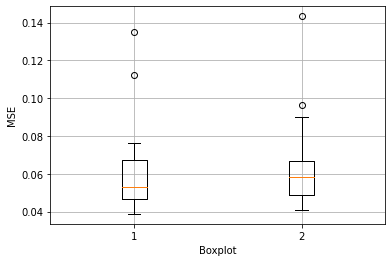

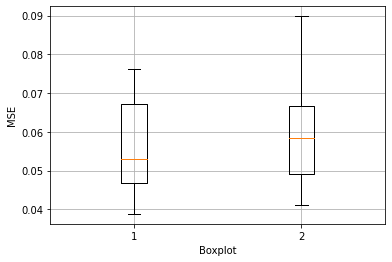

In [ ]:
modelo0_sample = result_table00.sample(30)
modelo1_sample = result_table01.sample(30)

creating_two_boxplot(result_table00['coeficiente de determinação'],result_table01['coeficiente de determinação'],'Coeficiente de determinação',False,True,'box_plot_r2')

creating_two_boxplot(result_table00['coeficiente de determinação'],result_table01['coeficiente de determinação'],'Coeficiente de determinação',True,True,'box_plot_r2_outliers')

creating_two_boxplot(result_table00['MSE'],result_table01['MSE'],'MSE',True,True,'box_plot_MSE_outliers')

creating_two_boxplot(result_table00['MSE'],result_table01['MSE'],'MSE',False,True,'box_plot_MSE')



#The hypothesis test#

Based on the set of the hyperparameters that produced the highest $r^2$ in simulation 1 and simulation 2, 2 same-size data sets are created using them. In order to ensure that one set of the hyperparameters is better than the other one in terms of mean, the hypothesis test is carried out following the below statements.

$h_{0} :$ Both means are statistically similar.

$h_{1} :$ The means of the distributions underlying the samples are unequal

If the p-value is less or equals 0.05, the null hypothesis($h_{0}$) is rejected and the alternative hypothesis($h_{1}$) is accepted. Otherwise, if the p-value is larger than 0.05, the $h_0$ is accepted. In relation to this project, accepting the $h_0$ means that both sets of hyperparameters produce the same results statistically speaking. Thus, it is more advantageous to work with the first one as it uses fewer features.  

https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ttest_ind.html

## Mean and standard deviation of both samples

To verify how far the two result sets are from each other in terms of the mean and standard deviation of metrics $r^2$ and MSE.

In [ ]:
print(f"r^2 da simulação 0: Media={modelo0_sample['coeficiente de determinação'].mean()} e DP = {modelo0_sample['coeficiente de determinação'].std()}")
print(f"r^2 da simulação 1: Media={modelo1_sample['coeficiente de determinação'].mean()} e DP = {modelo1_sample['coeficiente de determinação'].std()}")
print(f"MSE da simulação 0: Media={modelo0_sample['MSE'].mean()} e DP = {modelo0_sample['MSE'].std()}")
print(f"MSE da simulação 1: Media={modelo1_sample['MSE'].mean()} e DP = {modelo1_sample['MSE'].std()}")

r^2 da simulação 0: Media=0.9331581905813545 e DP = 0.023421789163097992
r^2 da simulação 1: Media=0.9325057242052583 e DP = 0.015534780210381103
MSE da simulação 0: Media=0.05926193569714684 e DP = 0.0207657538802122
MSE da simulação 1: Media=0.05984041226385038 e DP = 0.01377313322161663


##Performing the T-test

The T-test is going to tell us whether the result sets have different means. That test will be applied twice in each result set based on the metrics $r^2$ and MSE.

### MSE

In [ ]:
t_test_p_value_r2 = ttest_ind(modelo0_sample['coeficiente de determinação'],modelo1_sample['coeficiente de determinação'],alternative='two-sided',equal_var=False)[1]

if t_test_p_value_r2 <= 0.05:
  print("ambas populações não apresentam a mesma média")
else:
  print("ambas populações apresentam a mesma média")

print(t_test_p_value_r2)

ambas populações apresentam a mesma média
0.8993246856730389


###$r^2$

In [ ]:
t_test_p_value_MSE = ttest_ind(modelo0_sample['MSE'],modelo1_sample['MSE'],alternative='two-sided',equal_var=False)[1]

if t_test_p_value_MSE <= 0.05:
  print("ambas populações não apresentam a mesma média")
else:
  print("ambas populações apresentam a mesma média")

print(t_test_p_value_MSE)

ambas populações apresentam a mesma média
0.7293916319756488


#checking the correlation between the features and target variable.

To measure the correlation, the Pearson correlation coefficient is obtained for each available feature in the model in relation to the target variable, providing the direction and strength of that relationship. This metric varies from -1 to 1, for larger values than 0, the correlation is positive. for smaller values than 0, the correlation is negative then it gives opposite directions which means the increase in the feature causes the decrease in the target. the closer that metric is to the 1 and -1 values, the stronger is that correlation.

In [ ]:
correlation_of_features = r_regression(dataFrame.drop(columns={'latitude','longitude','altura','estacao_id','dia do ano','data completa','Eo_FAO','mes','ano'}),dataFrame['Eo_FAO'])
features_name = dataFrame.drop(columns={'latitude','longitude','altura','estacao_id','dia do ano','data completa','Eo_FAO','mes','ano'}).keys()
correlations_table = dict()

for index in range(len(features_name)):
  correlations_table[index] = features_name[index]
  
pd.DataFrame(correlation_of_features).T.rename(columns=correlations_table)

,TEMPERATURA MAXIMA NA HORA ANT. (AUT)(°C),UMIDADE REL. MAX. NA HORA ANT. (AUT)(%),TEMPERATURA MINIMA NA HORA ANT. (AUT)(°C),UMIDADE REL. MIN. NA HORA ANT. (AUT)(%),RADIACAO GLOBAL(Kj/m²),"PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA(mB)","UMIDADE RELATIVA DO AR, HORARIA(%)","VENTO, VELOCIDADE HORARIA(m/s)",temperatura media,Eo_samani
0,0.81284,-0.291154,0.030777,-0.715946,0.079393,0.148632,-0.575127,-0.085032,0.576381,0.967537


#Comparing the best results to the "Hargreaves and Samani" method

In [ ]:
if load_dataset_from_excel:
  [modelo,history] = make_prediction(dataFrame,best_results_of_simulation01[len(best_results_of_simulation00)]['parameters'])
else:
  results_of_simulation00 = sorted(best_results_of_simulation00, key=lambda item: item[1]['result_R2'])
  [modelo,history] = make_prediction(dataFrame,best_results_of_simulation01[len(best_results_of_simulation00)-1][1]['parameters'])



0.9380289150842864


O r^2 de samani = 0.932471018195344 e da rede neural = 0.947851801405042
O MSE de samani = 0.06431995881581858 e da rede neural = 0.04560908322175896


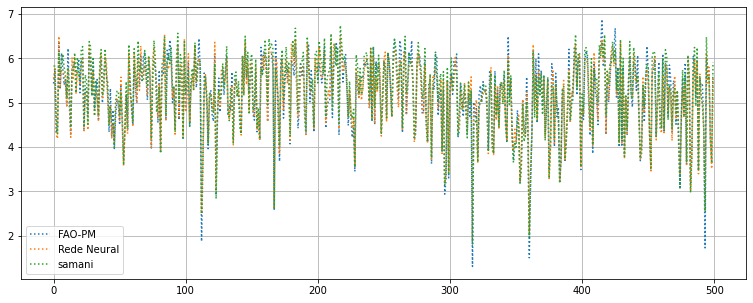

In [ ]:
r_2_samani = r2_score(samani_neural_FM['samani'],samani_neural_FM['FAO'])
r_2_rede = r2_score(samani_neural_FM['Rede_Neural'],samani_neural_FM['FAO'])
mse_samani = mean_squared_error(samani_neural_FM['samani'],samani_neural_FM['FAO'])
mse_rede = mean_squared_error(samani_neural_FM['Rede_Neural'],samani_neural_FM['FAO'])
print(f"O r^2 de samani = {r_2_samani} e da rede neural = {r_2_rede}")
print(f"O MSE de samani = {mse_samani} e da rede neural = {mse_rede}")

plt.figure(figsize=(13,5))
plt.plot(samani_neural_FM['FAO'][0:500].reset_index(drop=True),':',label="FAO-PM")
plt.plot(samani_neural_FM['Rede_Neural'][0:500].reset_index(drop=True),':',label="Rede Neural")
plt.plot(samani_neural_FM['samani'][0:500].reset_index(drop=True),':',label="samani")
plt.legend()
plt.grid()
plt.show()

In [ ]:
samani_neural_FM = pd.DataFrame([modelo.test_labels.values,modelo.test_samani.values,modelo.prediction_test.values,modelo.estacao_id.values,modelo.ano.values,modelo.mes.values]).rename({0:'FAO',1:'samani',2:'Rede_Neural',3:'id_estação',4:'ano',5:'mes'},axis=0).T
samani_neural_FM = samani_neural_FM.set_index(modelo.test_samani.index)
samani_neural_FM_2018 = samani_neural_FM[samani_neural_FM['ano']=='2018'] 
display(samani_neural_FM_2018)
display(samani_neural_FM)


,FAO,samani,Rede_Neural,id_estação,ano,mes
data completa,,,,,,
2018-01-02,5.434483,5.82768,5.544982,7.0,2018,01
2018-01-02,5.707716,5.826797,5.798999,9.0,2018,01
2018-01-02,4.318784,4.681724,4.288737,12.0,2018,01
2018-01-02,4.41712,4.299231,4.189776,2.0,2018,01
2018-01-02,6.342509,6.139779,6.500803,3.0,2018,01
...,...,...,...,...,...,...
2018-12-31,5.723823,5.740018,5.542084,1.0,2018,12
2018-12-31,5.429469,5.428772,5.419967,9.0,2018,12
2018-12-31,4.325008,4.376948,4.299778,0.0,2018,12


,FAO,samani,Rede_Neural,id_estação,ano,mes
data completa,,,,,,
2018-01-02,5.434483,5.82768,5.544982,7.0,2018,01
2018-01-02,5.707716,5.826797,5.798999,9.0,2018,01
2018-01-02,4.318784,4.681724,4.288737,12.0,2018,01
2018-01-02,4.41712,4.299231,4.189776,2.0,2018,01
2018-01-02,6.342509,6.139779,6.500803,3.0,2018,01
...,...,...,...,...,...,...
2021-11-25,1.522445,2.675081,2.429293,6.0,2021,11
2021-11-25,5.812633,6.080582,5.883811,9.0,2021,11
2021-11-25,5.834698,5.976913,5.937414,4.0,2021,11


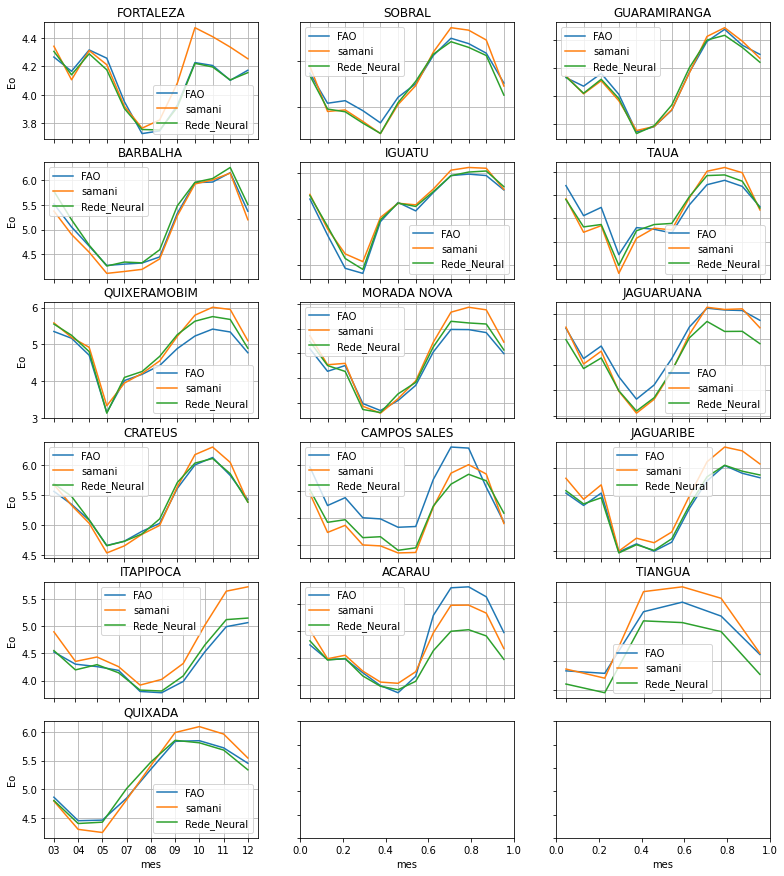

In [ ]:
fig, axs = plt.subplots(6, 3,figsize=(13,15))
labels = ['FAO','samani','Rede_Neural']
line_number = 0
count = 0
for id in range(len(localization)):
  

  for j in range(3):  
    axs[line_number,count].plot(samani_neural_FM_2018_grouped_by_id_estation_and_month[labels[j]][id],label=labels[j])
    axs[line_number,count].set_title(localization[id])
    axs[line_number,count].legend()
    axs[line_number,count].grid()

  count+=1

  if (id+1)%3==0:
    line_number+=1
    count=0

for ax in axs.flat:
    ax.set(xlabel='mes', ylabel='Eo')

for ax in axs.flat:
    ax.label_outer()

In [ ]:
samani_neural_FM_groupby_month = [ data for data in samani_neural_FM.drop(columns=['ano','mes']).groupby(['id_estação'])]
data = []
for id in range(len(localization)):
  data.append([localization[id],id_2[id],r2_score(samani_neural_FM_groupby_month[id][1]['FAO'],samani_neural_FM_groupby_month[id][1]['samani']),r2_score(samani_neural_FM_2018_groupby_month[id][1]['Rede_Neural'],samani_neural_FM_2018_groupby_month[id][1]['FAO']),mean_squared_error(samani_neural_FM_2018_groupby_month[id][1]['FAO'],samani_neural_FM_2018_groupby_month[id][1]['samani']),mean_squared_error(samani_neural_FM_groupby_month[id][1]['Rede_Neural'],samani_neural_FM_groupby_month[id][1]['FAO'])])
table_comparison = pd.DataFrame(data).rename(columns={0:"Nome da estação",1:"id da estação",2:"Samani(r^2)",3:"RNA(r^2)",4:"Samani(MSE)",5:"RNA(MSe)"})
display(table_comparison)

,Nome da estação,id da estação,Samani(r^2),RNA(r^2),Samani(MSE),RNA(MSe)
0,FORTALEZA,A305,0.859966,0.953224,0.023093,0.014075
1,SOBRAL,A306,0.916158,0.941206,0.047516,0.067213
2,GUARAMIRANGA,A314,0.965170,0.958582,0.030085,0.034270
3,BARBALHA,A315,0.981142,0.969047,0.020491,0.025418
4,IGUATU,A319,0.950204,0.961505,0.094084,0.030332
5,TAUA,A324,0.859203,0.910400,0.082433,0.038366
6,QUIXERAMOBIM,A325,0.681905,0.879177,0.144923,0.074368
7,MORADA NOVA,A332,0.875296,0.960017,0.074507,0.023515
8,JAGUARUANA,A339,0.752540,0.797513,0.041513,0.078877
9,CRATEUS,A342,0.955946,0.979873,0.018345,0.011549


In [ ]:
display(table_comparison[table_comparison['Samani(r^2)']<table_comparison['RNA(r^2)']])
display(f"melhores resultados em {len(table_comparison[table_comparison['Samani(r^2)']<table_comparison['RNA(r^2)']])} estações")
display(table_comparison[table_comparison['Samani(MSE)']>table_comparison['RNA(MSe)']])
display(f"melhores resultados em {len(table_comparison[table_comparison['Samani(MSE)']>table_comparison['RNA(MSe)']])} estações")

,Nome da estação,id da estação,Samani(r^2),RNA(r^2),Samani(MSE),RNA(MSe)
0,FORTALEZA,A305,0.859966,0.953224,0.023093,0.014075
1,SOBRAL,A306,0.916158,0.941206,0.047516,0.067213
4,IGUATU,A319,0.950204,0.961505,0.094084,0.030332
5,TAUA,A324,0.859203,0.910400,0.082433,0.038366
6,QUIXERAMOBIM,A325,0.681905,0.879177,0.144923,0.074368
7,MORADA NOVA,A332,0.875296,0.960017,0.074507,0.023515
8,JAGUARUANA,A339,0.752540,0.797513,0.041513,0.078877
9,CRATEUS,A342,0.955946,0.979873,0.018345,0.011549
11,JAGUARIBE,A358,0.900066,0.975955,0.068937,0.019089
12,ITAPIPOCA,A359,0.689727,0.956305,0.159868,0.016406


'melhores resultados em 11 estações'

,Nome da estação,id da estação,Samani(r^2),RNA(r^2),Samani(MSE),RNA(MSe)
0,FORTALEZA,A305,0.859966,0.953224,0.023093,0.014075
4,IGUATU,A319,0.950204,0.961505,0.094084,0.030332
5,TAUA,A324,0.859203,0.910400,0.082433,0.038366
6,QUIXERAMOBIM,A325,0.681905,0.879177,0.144923,0.074368
7,MORADA NOVA,A332,0.875296,0.960017,0.074507,0.023515
9,CRATEUS,A342,0.955946,0.979873,0.018345,0.011549
10,CAMPOS SALES,A347,0.796499,0.564073,0.213260,0.108271
11,JAGUARIBE,A358,0.900066,0.975955,0.068937,0.019089
12,ITAPIPOCA,A359,0.689727,0.956305,0.159868,0.016406
15,QUIXADA,A369,0.933997,0.969730,0.027246,0.013658


'melhores resultados em 10 estações'